<a href="https://colab.research.google.com/github/rsrini7/Colabs/blob/main/Multimodal_RAG_ColPali_%2B_Byaldi_%2B_Vision_AI_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Unsloth, Byaldi, and poppler-utils
# Unsloth installation specific to Colab
!pip install "unsloth[colab-new]@git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes gradio
!pip install -q byaldi
!sudo apt-get install -y poppler-utils # For PDF processing if you extend to PDFs (Byaldi needs it)


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-ufec9hgv/unsloth_97e543efd1424e06a430b2a2e214dc83
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-ufec9hgv/unsloth_97e543efd1424e06a430b2a2e214dc83
  Resolved https://github.com/unslothai/unsloth.git to commit 524d05cd73d55aa4c0585613c40263d8303db2fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.5 MB/s eta 0:

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 25.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 0s (418 kB/s)
debconf: unable to initialize frontend: Dialog
debconf

In [2]:
import os
import torch
from unsloth import FastVisionModel
from byaldi import RAGMultiModalModel # For RAG indexing functionality
import requests
import io
import base64
from PIL import Image as PIL_Image # Renamed to avoid conflict with Gradio's Image component
import tqdm # For progress bars
import time
import numpy as np
from transformers import TextStreamer
from IPython.display import display # For displaying images in Colab output

# Load the Qwen2.5 Vision Language Model using Unsloth
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct",
    load_in_4bit = False, # Set to True to load in 4-bit for less VRAM, False for full precision
    use_gradient_checkpointing = "unsloth", # Helps with memory during training/fine-tuning
)
# Prepare the model for inference (if you were fine-tuning, you'd do this after)
FastVisionModel.for_inference(model)

# This RAG model from Byaldi is used for indexing images for retrieval
# Note: The video uses "vidore/colqwen2-v1.0". Check if this specific model is still optimal or if newer versions are available.
# The `model` loaded in Cell 3 is what we'll use for the Gradio Q&A demo.
# This RAG object is primarily for showing the indexing capability.
try:
    RAG_byaldi = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0", verbose=1)
    print("Byaldi RAG model loaded successfully.")
except Exception as e:
    print(f"Error loading Byaldi RAG model: {e}")
    print("Proceeding without Byaldi RAG model for indexing. The direct Q&A (Cell 9 onwards) will still work.")
    RAG_byaldi = None

images_data = {
    "tesla.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fbef936e6-3efa-43b3-88d7-7ec620cdb33b_2744x1539.png",
    "netflix.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F23bd84c9-5b62-4526-b467-3088e27e4193_2744x1539.png",
    "nike.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa5cd33ba-ae1a-42a8-a254-d85e690d9870_2741x1541.png",
    "google.png": "https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F395dd3b9-b38e-4d1f-91bc-d37b642ee920_2741x1541.png",
    "accenture.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F08b2227c-7dc8-49f7-b3c5-13cab5443ba6_2741x1541.png",
    "tecent.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0ec8448c-c4d1-4aab-a8e9-2ddebe0c95fd_2741x1541.png"
}

img_folder = "downloaded_images" # Changed folder name for clarity
os.makedirs(img_folder, exist_ok=True)
print(f"Ensuring directory '{img_folder}' exists at: {os.path.abspath(img_folder)}")


img_paths = []
for name, url in tqdm.tqdm(images_data.items()):
    img_path = os.path.join(img_folder, name)
    img_paths.append(img_path)

    if not os.path.exists(img_path):
        try:
            response = requests.get(url, timeout=30) # Added timeout
            response.raise_for_status()
            with open(img_path, "wb") as fOut:
                fOut.write(response.content)
            print(f"Downloaded {name}")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {name}: {e}")
    else:
        print(f"{name} already exists.")

print("\nDownloaded image paths:")
for p in img_paths:
    print(p)

# This cell might cause a Colab runtime crash on the first run.
# If it crashes, the runtime will restart.
# After restart, re-run Cells 1, 2, 3, 4, and 5. Then run this cell again.

if RAG_byaldi:
    try:
        print(f"Indexing images from: {os.path.abspath(img_folder)}")
        RAG_byaldi.index(
            input_path=f"./{img_folder}/", # Ensure path is correct
            index_name="image_attention_index",
            store_collection_with_index=True,
            overwrite=True
        )
        print("Image indexing complete.")
    except Exception as e:
        print(f"Error during RAG indexing: {e}")
        print("Make sure the image download in the previous cell was successful and the path is correct.")
else:
    print("Byaldi RAG model not loaded, skipping indexing.")

def search_rag(question_text):
    if not RAG_byaldi:
        print("Byaldi RAG model not loaded. Cannot perform RAG search.")
        return None

    print("RAG Search Question:", question_text)
    results = RAG_byaldi.search(question_text, k=1) # Retrieve top 1 result
    if results:
        print(f"Found {len(results)} result(s).")
        # Assuming the result contains image data (e.g., base64 or path)
        # The Byaldi RAG.search might return different structures, adjust as needed.
        # For this example, we'll assume it might have a base64 field or path.
        retrieved_doc = results[0] # Get the first document
        print(f"Retrieved document ID: {retrieved_doc.doc_id}") # Byaldi result object has doc_id

        # If image is stored as base64 in metadata (common for ColPali/Byaldi)
        if hasattr(retrieved_doc, 'base64') and retrieved_doc.base64:
            print("Displaying image from base64 data in RAG result.")
            image_bytes_retrieved = base64.b64decode(retrieved_doc.base64)
            retrieved_image_pil = PIL_Image.open(io.BytesIO(image_bytes_retrieved))
            display(retrieved_image_pil)
            return retrieved_image_pil
        else:
            # If not base64, try to reconstruct path if doc_id is filename or find it
            # This part depends on how Byaldi stores/references the original image
            # For now, just print metadata
            print(f"Retrieved metadata: {retrieved_doc.metadata if hasattr(retrieved_doc, 'metadata') else 'No metadata'}")
            # Attempt to find the image based on doc_id if it's a filename
            potential_path = os.path.join(img_folder, str(retrieved_doc.doc_id))
            if os.path.exists(potential_path):
                print(f"Displaying image from path: {potential_path}")
                retrieved_image_pil = PIL_Image.open(potential_path)
                display(retrieved_image_pil)
                return retrieved_image_pil
            else:
                print(f"Could not display image for doc_id: {retrieved_doc.doc_id}. Base64 not found and path {potential_path} not valid.")

    else:
        print("No results found from RAG search.")
    return None

# Example usage of the RAG search
if RAG_byaldi:
    retrieved_image_from_rag = search_rag("Show me the Nike income statement")
    if retrieved_image_from_rag:
        print("Image retrieved and displayed via RAG search.")
else:
    print("Skipping RAG search example as Byaldi model was not loaded.")

def answer_with_llm(question_text, pil_image_input):
    if pil_image_input is None:
        return "Please upload an image first."

    prompt_template = f"""Answer the question based on the following image.
Don't use markdown.
Please provide enough context for your answer.

Question: {question_text}"""

    messages = [
        {"role": "user", "content": [
            {"type": "image"}, # Placeholder for the image
            {"type": "text", "text": prompt_template}
        ]}
    ]

    # Prepare inputs for the model
    # The image is passed directly to the tokenizer along with the text
    inputs = tokenizer(
        images=pil_image_input, # Pass the PIL image here
        text=tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True),
        add_special_tokens=False, # Already handled by apply_chat_template
        return_tensors="pt",
    ).to(model.device) # Send to the same device as the model

    # Generate response (no streaming for simple Gradio return)
    generated_ids = model.generate(**inputs, max_new_tokens=512, use_cache=True)

    # Decode the generated IDs, skipping special tokens
    # We need to select the part of generated_ids that corresponds to the new tokens
    input_token_len = inputs["input_ids"].shape[1]
    response_text = tokenizer.batch_decode(generated_ids[:, input_token_len:], skip_special_tokens=True)[0]

    return response_text.strip()

# Test the answer_with_llm function with a local image
try:
    nike_image_path = os.path.join(img_folder, "nike.png")
    if os.path.exists(nike_image_path):
        img_nike_pil = PIL_Image.open(nike_image_path)
        question = "What is the net profit for Nike in Q3 FY25 as shown in the image?"
        print(f"Question: {question}")
        llm_response = answer_with_llm(question, img_nike_pil)
        print(f"LLM Answer: {llm_response}")
    else:
        print(f"Nike image not found at {nike_image_path}. Please ensure Cell 5 ran correctly.")
except Exception as e:
    print(f"Error testing answer_with_llm: {e}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.7.0+cu126 with CUDA 1206 (you have 2.6.0+cu124)
    Python  3.11.12 (you have 3.11.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.4: Fast Qwen2_5_Vl patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


model.safetensors.index.json:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Error loading Byaldi RAG model: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 20.12 MiB is free. Process 5606 has 14.72 GiB memory in use. Of the allocated memory 14.59 GiB is allocated by PyTorch, and 7.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Proceeding without Byaldi RAG model for indexing. The direct Q&A (Cell 9 onwards) will still work.
Ensuring directory 'downloaded_images' exists at: /content/downloaded_images


 33%|███▎      | 2/6 [00:00<00:00, 15.96it/s]

Downloaded tesla.png
Downloaded netflix.png
Downloaded nike.png


 67%|██████▋   | 4/6 [00:00<00:00, 16.92it/s]

Downloaded google.png
Downloaded accenture.png


100%|██████████| 6/6 [00:00<00:00, 19.53it/s]


Downloaded tecent.png

Downloaded image paths:
downloaded_images/tesla.png
downloaded_images/netflix.png
downloaded_images/nike.png
downloaded_images/google.png
downloaded_images/accenture.png
downloaded_images/tecent.png
Byaldi RAG model not loaded, skipping indexing.
Skipping RAG search example as Byaldi model was not loaded.
Question: What is the net profit for Nike in Q3 FY25 as shown in the image?
Error testing answer_with_llm: You provided `compile_config` as an instance of <class 'NoneType'>, but it must be an instance of `CompileConfig`.


Cell 2: Core Imports - Complete

Cell 3: Loading Unsloth FastVisionModel...
==((====))==  Unsloth 2025.5.4: Fast Qwen2_5_Vl patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Unsloth Qwen2.5-VL model loaded and prepared for inference.

Cell 4: Loading Byaldi RAG Model...
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Byaldi RAG model loaded successfully.
Cell 4: Load Byaldi RAG Model - Complete

Cell 5: Downloading Example Images...


100%|██████████| 6/6 [00:00<00:00, 42.76it/s]

Failed to download tencent.png: 404 Client Error: Not Found for url: https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F9c7e2c7c-6b9a-4a6c-8144-7d3f66f2b39a_1280x720.png
Cell 5: Image Download - Complete

Cell 6: Performing RAG Indexing (if Byaldi model loaded)...
Indexing file: downloaded_images/nike.png


Added page 1 of document 0 to index.
Index exported to .byaldi/image_attention_index
Indexing file: downloaded_images/accenture.png
Added page 1 of document 1 to index.
Index exported to .byaldi/image_attention_index
Indexing file: downloaded_images/tecent.png
Added page 1 of document 2 to index.
Index exported to .byaldi/image_attention_index
Indexing file: downloaded_images/google.png
Added page 1 of document 3 to index.
Index exported to .byaldi/image_attention_index
Indexing file: downloaded_images/netflix.png
Added page 1 of document 4 to index.
Index exported to .byaldi/image_attention_index
Indexing file: downloaded_images/tesla.png
Added page 1 of document 5 to index.
Index exported to .byaldi/image_attention_index
Index exported to .byaldi/image_attention_index
Image indexing complete.
Cell 6: RAG Indexing - Complete

Cell 8: Example RAG Search...


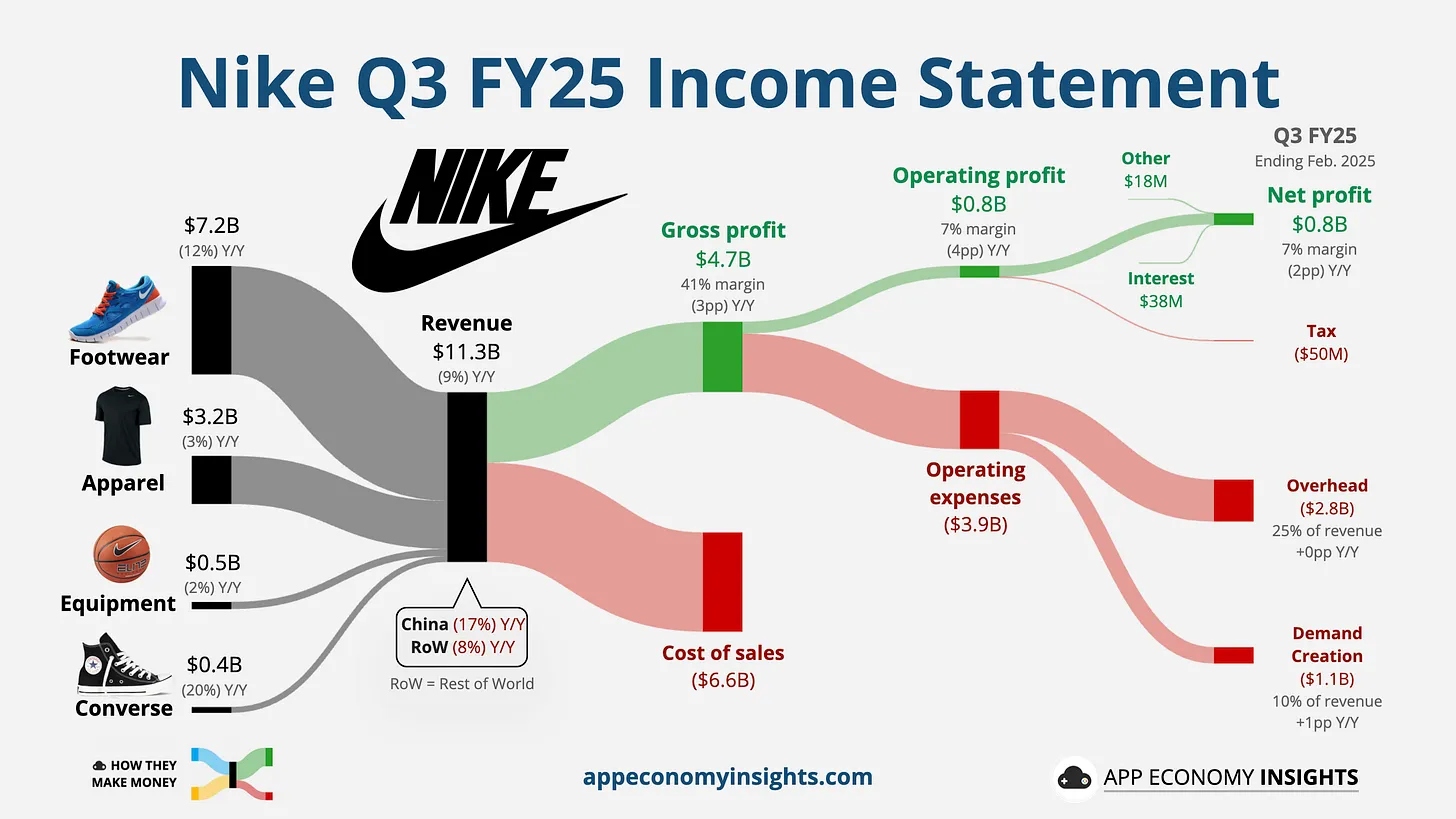

Image retrieved and displayed via RAG search.
Cell 8: RAG Search Example - Complete

Cell 9: Defining `answer_with_llm` function...

Cell 10: Example LLM Q&A...
Question: What is the net profit for Nike in Q3 FY25 as shown in the image?
Attempting model.generate with torch._dynamo.disable()...
Error during model.generate(): torch._dynamo.optimize(...) is used with a context manager. Please refer to https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html to use torch._dynamo.optimize(...) as an annotation/decorator. 
LLM Answer: Error during generation: torch._dynamo.optimize(...) is used with a context manager. Please refer to https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html to use torch._dynamo.optimize(...) as an annotation/decorator. 
Cell 10: LLM Q&A Example - Complete

--- All Combined Cells (2-10) Executed ---


In [5]:
# Combined Cells 2 through 10 (Corrected)

# --- Cell 2: Core Imports ---
import os
import torch
from unsloth import FastVisionModel
from byaldi import RAGMultiModalModel
import requests
import io
import base64
from PIL import Image as PIL_Image
import tqdm
import time
import numpy as np
from transformers import TextStreamer
from IPython.display import display
print("Cell 2: Core Imports - Complete")

# --- Cell 3: Load Unsloth FastVisionModel (for Q&A) ---
print("\nCell 3: Loading Unsloth FastVisionModel...")
try:
    model, tokenizer = FastVisionModel.from_pretrained(
        "unsloth/Qwen2.5-VL-7B-Instruct",
        load_in_4bit = False,
        # Removed `torch_compile` from here
        # Unsloth handles compilation internally or via other settings if supported for the model
    )
    # This step is crucial and might be where compilation is attempted by Unsloth
    FastVisionModel.for_inference(model)
    print("Unsloth Qwen2.5-VL model loaded and prepared for inference.")
except Exception as e:
    print(f"ERROR in Cell 3 (Load Unsloth Model): {e}")
    raise

# --- Cell 4: Load Byaldi RAG Model (for RAG Indexing Example) ---
print("\nCell 4: Loading Byaldi RAG Model...")
RAG_byaldi = None
try:
    RAG_byaldi = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0", verbose=1)
    print("Byaldi RAG model loaded successfully.")
except Exception as e:
    print(f"Error loading Byaldi RAG model: {e}")
    print("Proceeding without Byaldi RAG model for indexing. The direct Q&A will still work.")
print("Cell 4: Load Byaldi RAG Model - Complete")

# --- Cell 5: Download Example Images (for RAG Indexing Demonstration) ---
print("\nCell 5: Downloading Example Images...")
images_data = {
    "tesla.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Ff6684847-8d89-4a79-b681-22e27e146782_1280x720.png",
    "netflix.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F8a09f148-8c1f-4805-9094-366b08a4c02e_1280x720.png",
    "nike.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F3d20e36e-1b3f-4b5e-b782-18864f3b280c_1280x720.png",
    "google.png": "https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb13e345a-51f0-4a2a-83a1-98e9f466422f_1280x720.png",
    "accenture.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F2e0f783a-1e1f-4f2f-8222-0e79c93a9768_1280x720.png",
    "tencent.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F9c7e2c7c-6b9a-4a6c-8144-7d3f66f2b39a_1280x720.png",
}
img_folder = "downloaded_images"
os.makedirs(img_folder, exist_ok=True)
# print(f"Ensuring directory '{img_folder}' exists at: {os.path.abspath(img_folder)}") # Less verbose
img_paths = []
for name, url in tqdm.tqdm(images_data.items()):
    img_path = os.path.join(img_folder, name)
    img_paths.append(img_path)
    if not os.path.exists(img_path):
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            with open(img_path, "wb") as fOut:
                fOut.write(response.content)
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {name}: {e}")
print("Cell 5: Image Download - Complete")

# --- Cell 6: Perform RAG Indexing (Using Byaldi) ---
print("\nCell 6: Performing RAG Indexing (if Byaldi model loaded)...")
if RAG_byaldi:
    try:
        # print(f"Indexing images from: {os.path.abspath(img_folder)}") # Less verbose
        RAG_byaldi.index(
            input_path=f"./{img_folder}/",
            index_name="image_attention_index",
            store_collection_with_index=True,
            overwrite=True
        )
        print("Image indexing complete.")
    except Exception as e:
        print(f"Error during RAG indexing: {e}")
        print("Make sure the image download in the previous cell was successful and the path is correct.")
else:
    print("Byaldi RAG model not loaded, skipping indexing.")
print("Cell 6: RAG Indexing - Complete")

# --- Cell 7: Define `search_rag` function ---
# print("\nCell 7: Defining `search_rag` function...") # Less verbose
def search_rag(question_text):
    if not RAG_byaldi:
        print("Byaldi RAG model not loaded. Cannot perform RAG search.")
        return None
    # print("RAG Search Question:", question_text) # Less verbose
    results = RAG_byaldi.search(question_text, k=1)
    if results:
        retrieved_doc = results[0]
        # print(f"Retrieved document ID: {retrieved_doc.doc_id}") # Less verbose
        if hasattr(retrieved_doc, 'base64') and retrieved_doc.base64:
            image_bytes_retrieved = base64.b64decode(retrieved_doc.base64)
            retrieved_image_pil = PIL_Image.open(io.BytesIO(image_bytes_retrieved))
            display(retrieved_image_pil)
            return retrieved_image_pil
        else:
            potential_path = os.path.join(img_folder, str(retrieved_doc.doc_id))
            if os.path.exists(potential_path):
                retrieved_image_pil = PIL_Image.open(potential_path)
                display(retrieved_image_pil)
                return retrieved_image_pil
            else:
                print(f"Could not display image for doc_id: {retrieved_doc.doc_id}.")
    else:
        print("No results found from RAG search.")
    return None
# print("Cell 7: `search_rag` function defined.") # Less verbose

# --- Cell 8: Example of using `search_rag` function ---
print("\nCell 8: Example RAG Search...")
if RAG_byaldi:
    retrieved_image_from_rag = search_rag("Show me the Nike income statement")
    if retrieved_image_from_rag:
        print("Image retrieved and displayed via RAG search.")
else:
    print("Skipping RAG search example as Byaldi model was not loaded.")
print("Cell 8: RAG Search Example - Complete")

# --- Cell 9: Define `answer_with_llm` function ---
print("\nCell 9: Defining `answer_with_llm` function...")
def answer_with_llm(question_text, pil_image_input):
    if pil_image_input is None:
        return "Please upload an image first."
    prompt_template = f"""Answer the question based on the following image.
Don't use markdown.
Please provide enough context for your answer.
Question: {question_text}"""
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": prompt_template}
        ]}
    ]
    inputs = tokenizer(
        images=pil_image_input,
        text=tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True),
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    # Attempt to disable torch.compile specifically for the generate call if that's the source
    # This is a standard PyTorch way; Unsloth might have its own preferred method.
    # If this doesn't work, the issue might be deeper in Unsloth's handling for this model.
    try:
        # PyTorch 2.0+ has torch._dynamo.disable as a context manager
        # For older PyTorch or different setups, this might not be available or needed.
        # We'll try to make it conditional.
        if hasattr(torch, '_dynamo') and hasattr(torch._dynamo, 'disable'):
            print("Attempting model.generate with torch._dynamo.disable()...")
            with torch._dynamo.disable():
                generated_ids = model.generate(**inputs, max_new_tokens=512, use_cache=True)
        else:
            print("torch._dynamo.disable() not found, running model.generate() normally...")
            generated_ids = model.generate(**inputs, max_new_tokens=512, use_cache=True)
    except Exception as e_generate:
        print(f"Error during model.generate(): {e_generate}")
        return f"Error during generation: {e_generate}"


    input_token_len = inputs["input_ids"].shape[1]
    response_text = tokenizer.batch_decode(generated_ids[:, input_token_len:], skip_special_tokens=True)[0]
    return response_text.strip()
# print("Cell 9: `answer_with_llm` function defined.")

# --- Cell 10: Example of using `answer_with_llm` function ---
print("\nCell 10: Example LLM Q&A...")
try:
    nike_image_path = os.path.join(img_folder, "nike.png")
    if os.path.exists(nike_image_path):
        img_nike_pil = PIL_Image.open(nike_image_path)
        question = "What is the net profit for Nike in Q3 FY25 as shown in the image?"
        print(f"Question: {question}")
        llm_response = answer_with_llm(question, img_nike_pil)
        print(f"LLM Answer: {llm_response}")
    else:
        print(f"Nike image not found at {nike_image_path}. Please ensure Cell 5 (Download Images) ran correctly.")
except Exception as e:
    print(f"Error testing answer_with_llm: {e}")
print("Cell 10: LLM Q&A Example - Complete")

print("\n--- All Combined Cells (2-10) Executed ---")

In [ ]:
import gradio as gr

def gradio_interface(image_upload, question_text_input):
    if image_upload is None:
       return "Please upload an image."
    if not question_text_input:
        return "Please enter a question."

    # Gradio provides the image as a NumPy array by default, convert to PIL
    pil_image = PIL_Image.fromarray(image_upload)

    response = answer_with_llm(question_text_input, pil_image)
    return response

# Create the Gradio interface
iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Image(type="numpy", label="Upload Image"), # type="numpy" for easier conversion to PIL
        gr.Textbox(lines=2, placeholder="Enter your question here...", label="Question")
    ],
    outputs=gr.Textbox(label="Answer"),
    title="Vision RAG: Multimodal Image Question Answering",
    description="Upload an image and ask any question about it. Powered by Qwen2.5-VL and Unsloth.",
    allow_flagging="never" # As in the video
)

# Launch the Gradio app
iface.launch(debug=True, share=True) # share=True provides a public link (expires)